# Evaluation and Serving of the LSTM with Attention, Improved Performance in Production and Edge Cases
This script demonstrates the process of evaluating, and serving an LSTM model with attention for intent classification on the ATIS dataset. We evaluate the model using different metrics 
1. Accuracy
2. Precision
3. Recall
4. Support
5. ROC curve, confusion matrix, classification report, etc..

## Improving model performace in production and handling edge cases 
also add some test/edge cases to show that how the model performance can be improved in production or how the out-of-sample detection can be made better. There can be many strategies to check the model performance in production. However we only work on two
### 1. Confidence Scores
### 2. Out-of-Sample Detection


Lets start!!

In [37]:
import pandas as pd
import torch
from machine_learning.IntentTokenizer import IntentTokenizer
from machine_learning.model_utils import train, evaluate, predict, get_or_create_experiment
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [38]:
# Determine the computation device based on availability
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


#### Load the tokenized and test datasets

In [23]:
# Specify the model name for loading
model_name = "best_ICELSTMAmodel"
# Load the trained model and tokenizer from saved files
model_serve = torch.load(f"models/{model_name}.pth").to(device)
tokenizer = tokenizer = IntentTokenizer.load_state(IntentTokenizer,f"models/{model_name}_tokenizer.pickle", f"models/IntentClassifierLSTMWithAttention_le.pickle")
# Load the test dataset for evaluation
test_df = pd.read_csv('data/atis/test.tsv', sep='\t', header=None, names=["text", "label"])

## Model Metrics: Evaluate the model on the test dataset
The following methods are used for evaluation:
- Accuracy
- Precision
- Recall
- F1 Score
- Confusion Matrix
- Precision-Recall Curve
- ROC Curve
- Classification Report

In [24]:
# Extract true labels from the test data
y_test = test_df['label'].values

# Predict labels using the trained model
y_pred = predict(model_serve, test_df, tokenizer, device)

# Compute accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Display the computed metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9623529411764706
Precision: 0.9622208692698067
Recall: 0.9623529411764706
F1 Score: 0.9599560750752281
                   precision    recall  f1-score   support

     abbreviation       1.00      0.92      0.96        26
         aircraft       1.00      0.75      0.86         8
          airfare       0.96      0.98      0.97        48
   airfare+flight       0.00      0.00      0.00         1
          airline       1.00      0.96      0.98        28
airline+flight_no       0.00      0.00      0.00         0
          airport       1.00      0.77      0.87        13
         capacity       1.00      0.95      0.98        21
             city       1.00      0.80      0.89         5
         day_name       0.00      0.00      0.00         2
         distance       1.00      0.90      0.95        10
           flight       0.97      0.99      0.98       613
   flight+airfare       0.83      0.42      0.56        12
   flight+airline       0.00      0.00      0.00         1

#### Visualize the confusion matrix


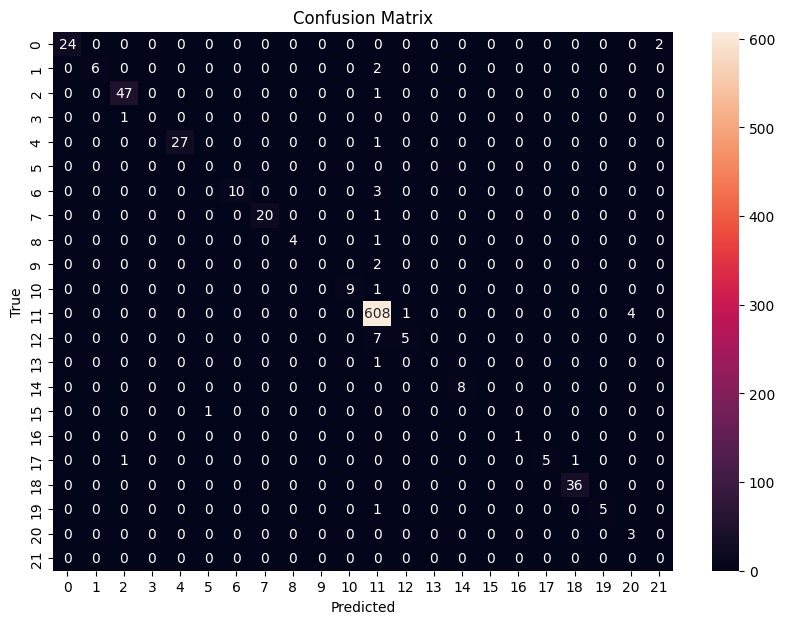

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### Visualize the precision-recall curve and ROC curve

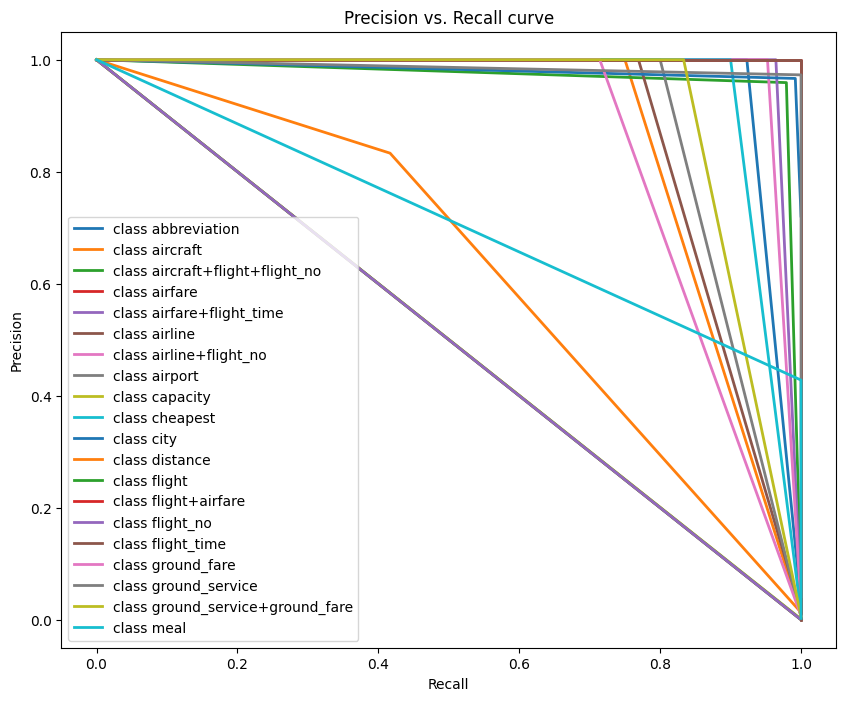

In [26]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class plots
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
y_pred_binarized = label_binarize(y_pred, classes=np.unique(y_test))

n_classes = y_test_binarized.shape[1]

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    plt.plot(recall, precision, lw=2, label=f'class {tokenizer.le.classes_[i]}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()

### Visualize ROC curve

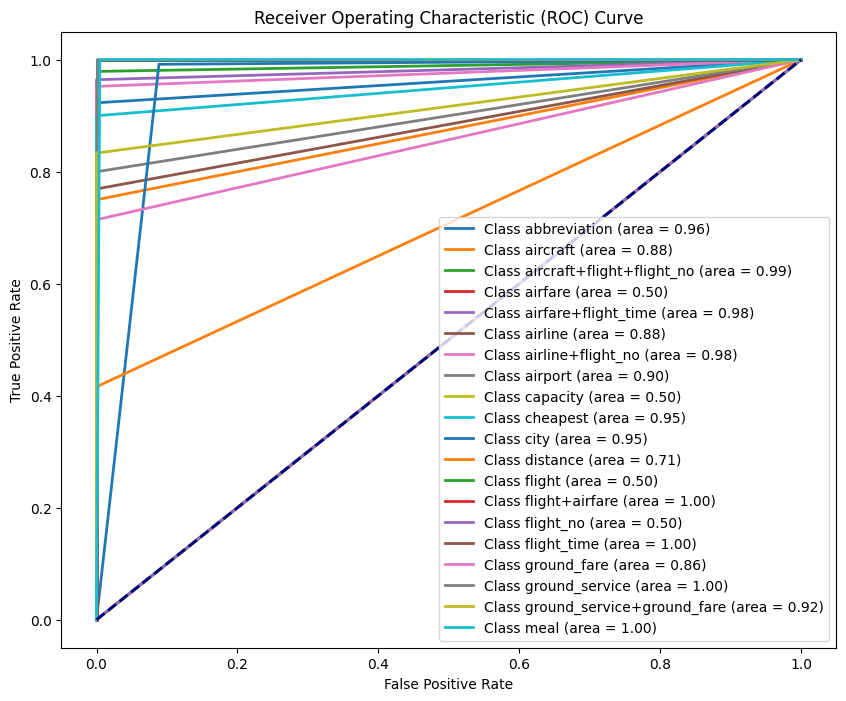

In [27]:

from sklearn.metrics import roc_curve, auc

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {tokenizer.le.classes_[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### Serve the model for prediction
1. Confidence Score Analysis
Confidence Distribution: Analyze the distribution of confidence scores for predictions. A well-performing model should generally have higher confidence scores.
Threshold Analysis: Determine how varying confidence thresholds affect the number of predicted intents. A stable model will show a consistent pattern in the distribution of predictions above certain confidence levels.
2. Error Analysis
Manual Review: Randomly sample a set of predictions and manually review them. This can provide qualitative insights into types of errors (e.g., systematic errors, rare cases).
Consistency Check: For applications with user feedback loops (like chatbots), monitor user actions following the model's response. Frequent user corrections or negative feedback can indicate issues.
3. Out-of-Distribution (OOD) Detection
OOD Samples: Use a separate dataset that the model hasn't seen, preferably containing out-of-distribution samples. Measure how the model's confidence scores differ on these samples.
OOD Metrics: Evaluate using metrics like Area Under the Receiver Operating Characteristic curve (AUROC) for OOD detection efficiency.
4. Comparative Analysis
A/B Testing: If possible, implement A/B testing where different models serve different user segments. Monitor indirect metrics like user engagement, session length, or conversion rates.
Sequential Testing: Periodically switch between models in production and monitor overall system performance metrics.
5. Model Drift Monitoring
Data Drift: Monitor for shifts in input data distribution over time. Significant drifts can suggest that the model might be becoming less effective.
Prediction Drift: Monitor changes in the distribution of the model's predictions. A sudden shift could indicate that the model's performance is degrading.
6. Feedback Loop
User Feedback: Implement a mechanism for users to provide feedback on predictions. This can be direct (like thumbs up/down) or inferred (like user ignoring the model's suggestion).
7. Additional Metrics
Latency: Measure the response time. A slower model might impact user experience negatively.
Resource Utilization: Monitor CPU, memory, and other resource usages. An efficient model should balance accuracy with resource consumption.

# Production time serving and edge cases
### Implementing confidence scores
1. Extracting Confidence Scores:
When making predictions with your model, you'll usually obtain not only the predicted labels but also the probabilities associated with each class. These probabilities can be interpreted as confidence scores.
For a given input text, the model outputs a confidence score for each possible intent. The intent with the highest score is typically chosen as the prediction.
2. Analyzing Confidence Scores:
Histogram of Confidence Scores: Plot a histogram of the confidence scores of all predictions. This will give you an idea of how certain the model is about its predictions. A well-performing model will have a distribution skewed towards higher confidence scores.
Average Confidence Score: Calculate the average confidence score across all predictions. A higher average indicates higher overall confidence of the model in its predictions.
3. Confidence Threshold Analysis:
Determine how different confidence thresholds affect the number of predicted intents and their perceived accuracy. For example, you might analyze how many predictions have confidence above 0.9, 0.8, etc.
Observing the drop-off in the number of predictions above certain confidence levels can provide insights into the model’s reliability.
4. Segment Analysis:
Break down the confidence scores by different segments such as time of day, user demographics, or type of query. This can help identify if the model performs consistently across different segments or if there are specific areas where confidence is notably lower.
6. Interpretation:
High Confidence, Poor Accuracy: If the model shows high confidence but poor accuracy, this might indicate overfitting or issues with the training data.
Low Confidence: Consistently low confidence scores might suggest the model is underfitting or not complex enough to capture the nuances of the data.
7. Use in Production:
Implement logging of confidence scores in your production system.
Regularly analyze these logs to monitor model performance.
Use the insights from this analysis for model retraining or adjustment decisions.
Remember, this analysis is part of a continuous monitoring strategy and should be adapted and expanded based on specific use cases and available data.

Number of test samples: torch.Size([850, 30])


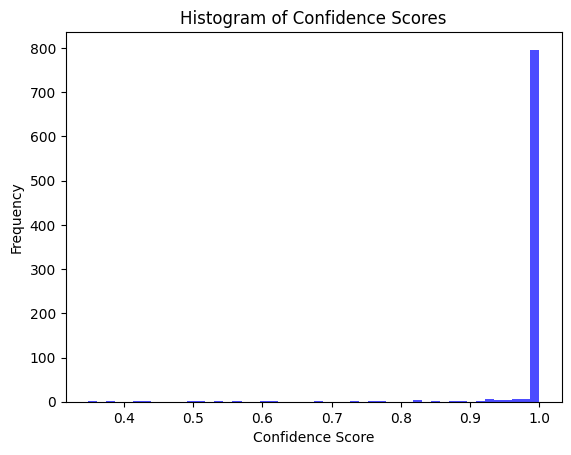

Average Confidence Score: 0.99


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
batch_size=32


model_name = "best_ICELSTMAmodel"
# Load the trained model and tokenizer from saved files
model = torch.load(f"models/{model_name}.pth").to(device)

test_data = tokenizer.process_data(test_df, device=device)
print("Number of test samples:", test_data.tensors[0].size())
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

confidence_scores = []
model.eval()

with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        max_probs, _ = torch.max(probabilities, dim=1)
        confidence_scores.extend(max_probs.cpu().numpy())

# Plotting histogram of confidence scores
plt.hist(confidence_scores, bins=50, alpha=0.7, color='blue')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Histogram of Confidence Scores')
plt.show()

# Calculating and printing average confidence score
average_confidence = np.mean(confidence_scores)
print(f'Average Confidence Score: {average_confidence:.2f}')

# OOS case: "I want to book a hotel room near Miami Beach", 
## How will the model respond?

In [54]:

# Your query string
query_str = "I want to book a hotel room near Miami Beach"
model_name = "best_ICELSTMAmodel"
# Load the trained model and tokenizer from saved files
model = torch.load(f"models/{model_name}.pth").to(device)
# Creating a DataFrame with the query string
query = pd.DataFrame([query_str], columns=['text'])
y_pred= predict(model, query, tokenizer, device)
y_pred

array(['flight'], dtype=object)

# Out-of-Distribution (OOD) Detection 

is crucial for neural network models, especially in a production environment, to identify when a model is making predictions on data that is significantly different from the data it was trained on. Here's how you can approach OOD detection:

1. Identifying OOD Samples:
Dataset Collection: Gather a dataset that represents data the model is likely to encounter but was not included in the training set. This could be newer data, data from different but related domains, or synthetically altered data.
Baseline Comparison: Compare the statistical distribution of the training data with the OOD data. Significant deviations in key features can indicate OOD samples.
2. Confidence Score Analysis for OOD:
Model Confidence on OOD Data: Run the OOD dataset through the model and observe the confidence scores. For a well-calibrated model, OOD samples should ideally result in lower confidence scores.
Histogram Comparison: Compare histograms of confidence scores for in-distribution (training set) and OOD data. Significant differences can help in setting confidence thresholds for OOD detection.
3. Implementing OOD Detection Metrics:
Rejection Rate: Measure the rate at which the model rejects predictions (confidence below a threshold) on OOD data versus in-distribution data.
Area Under the ROC Curve (AUROC): Use AUROC to measure the model's ability to distinguish between in-distribution and OOD data based on confidence scores.
4. Model Uncertainty Estimation:
Bayesian Neural Networks: Implement models that can estimate their own uncertainty. High uncertainty can be a signal for OOD data.
Ensemble Methods: Use an ensemble of models and consider variance in their predictions as a measure of uncertainty.

#### We created two Out-of-Sample files ood.tsv and ood_test.csv by asking chatgpt to include some edge cases. Their purpose will become clear later on

Number of ood samples: torch.Size([80, 12])
Number of ood samples: torch.Size([70, 12])


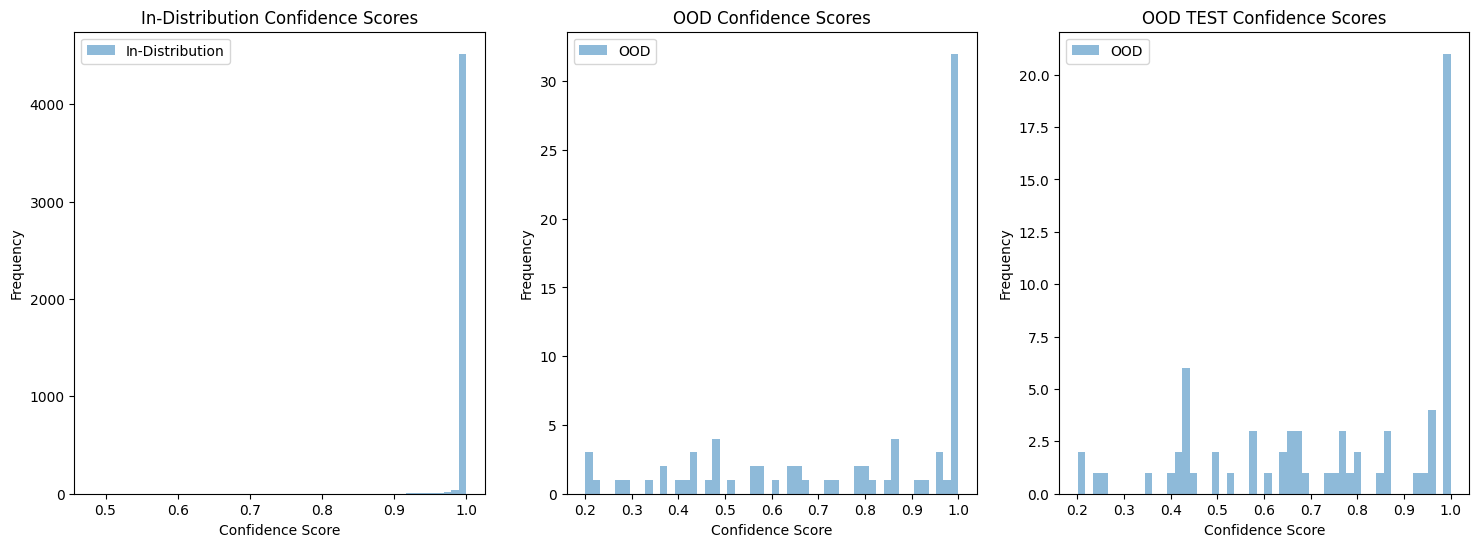

In [70]:
import torch
import numpy as np
import matplotlib.pyplot as plt

batch_size=32
model_name = "best_ICELSTMAmodel"
# Load the trained model and tokenizer from saved files
model = torch.load(f"models/{model_name}.pth").to(device)

def get_confidence_scores(model, data_loader):
    model.eval()
    confidence_scores = []
    with torch.no_grad():
        for inputs,_ in data_loader:
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            max_probs, _ = torch.max(probabilities, dim=1)
            confidence_scores.extend(max_probs.cpu().numpy())
    return confidence_scores

train_df = pd.read_csv('data/atis/train.tsv', sep='\t', header=None, names=["text", "label"])
train_data = tokenizer.process_data(train_df, device=device)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

ood_df=pd.read_csv('data/atis/ood.tsv', sep='\t', header=None, names=["text", "label"])
ood_data = tokenizer.process_data(ood_df, device=device)
ood_loader= DataLoader(ood_data, shuffle=True, batch_size=batch_size)
print("Number of ood samples:", ood_data.tensors[0].size())


ood_test_df=pd.read_csv('data/atis/ood_test.tsv', sep='\t', header=None, names=["text", "label"])
ood_test_data = tokenizer.process_data(ood_test_df, device=device)
ood_test_loader= DataLoader(ood_test_data, shuffle=True, batch_size=batch_size)
print("Number of ood samples:", ood_test_data.tensors[0].size())


# Assuming train_loader and ood_loader are DataLoader objects for your in-distribution and OOD data
train_confidence_scores = get_confidence_scores(model, train_loader)
ood_confidence_scores = get_confidence_scores(model, ood_loader)
ood_test_confidence_scores = get_confidence_scores(model, ood_test_loader)


# Creating subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plotting histograms on subplots
axs[0].hist(train_confidence_scores, bins=50, alpha=0.5, label='In-Distribution')
axs[0].set_title('In-Distribution Confidence Scores')
axs[0].set_xlabel('Confidence Score')
axs[0].set_ylabel('Frequency')
axs[0].legend()

axs[1].hist(ood_confidence_scores, bins=50, alpha=0.5, label='OOD')
axs[1].set_title('OOD Confidence Scores')
axs[1].set_xlabel('Confidence Score')
axs[1].set_ylabel('Frequency')
axs[1].legend()

axs[2].hist(ood_test_confidence_scores, bins=50, alpha=0.5, label='OOD')
axs[2].set_title('OOD TEST Confidence Scores')
axs[2].set_xlabel('Confidence Score')
axs[2].set_ylabel('Frequency')
axs[2].legend()
# Displaying the plots
plt.show()

### CHECK THE ACTUAL PREDICTIONS ON OOD AND OOD_TEST

In [71]:
print("How the model performs on OOD data")
y_pred=predict(model, ood_df, tokenizer, device)
print(y_pred)

print("How the model performs on OOD data Test")
y_pred=predict(model, ood_test_df, tokenizer, device)
print(y_pred)

How the model performs on OOD data
['flight' 'flight' 'flight' 'flight' 'flight' 'flight' 'flight'
 'flight_time' 'flight' 'aircraft' 'flight' 'flight' 'ground_service'
 'flight' 'flight' 'airport' 'flight' 'flight' 'distance' 'flight'
 'flight' 'abbreviation' 'flight' 'flight' 'flight' 'flight'
 'abbreviation' 'flight' 'flight' 'flight' 'flight' 'flight' 'flight'
 'airfare' 'flight' 'flight' 'flight' 'flight' 'flight' 'flight' 'flight'
 'flight' 'flight' 'flight' 'city' 'restriction' 'flight' 'flight'
 'flight' 'flight' 'flight' 'flight' 'flight' 'abbreviation' 'flight'
 'flight' 'flight' 'flight' 'aircraft' 'flight' 'restriction' 'flight'
 'flight' 'restriction' 'flight' 'flight' 'flight_time' 'flight' 'flight'
 'ground_service' 'flight' 'flight' 'flight' 'flight' 'flight' 'flight'
 'flight' 'flight' 'flight' 'abbreviation']
How the model performs on OOD data Test
['flight' 'flight' 'flight' 'flight' 'flight' 'flight' 'flight'
 'restriction' 'flight' 'flight' 'restriction' 'flight' '

# BAD NEWS!! Out-of-Sample Detection is poort

### Improving the model by adding an on ood_sample in the training data
The output above shows very worrying picture, the whole out of sample data is labelled according to known class. Therefore to make the out-of-sample detection better, we generate some fake training data for out of sample using chatgpt and add it to the training data to get ood detection better. This is akin to fine tuning with additional data in the training data.

In [72]:
import mlflow
from machine_learning.model_utils import get_or_create_experiment
experiment_id=get_or_create_experiment("ood_training_finetuning-best-experiment")
import torch.optim as optim
import torch.nn as nn

model_name = "best_ICELSTMAmodel"
# Load the trained model and tokenizer from saved files
model = torch.load(f"models/{model_name}.pth").to(device)

train_df = pd.read_csv('data/atis/train.tsv', sep='\t', header=None, names=["text", "label"])
ood_df=pd.read_csv('data/atis/ood.tsv', sep='\t', header=None, names=["text", "label"])
ood_data = tokenizer.process_data(ood_df, device=device)
ood_loader= DataLoader(ood_data, shuffle=True, batch_size=batch_size)

## *****Adding OOD Data to Training Data ****##
train_df=pd.concat([train_df,ood_df])
train_data = tokenizer.process_data(train_df, device=device)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
with mlflow.start_run():
    # Log the best parameters
    lr=0.0001
    weight_decay=1e-06
    optimizer = optim.Adam(model.parameters(), lr=lr,
                           weight_decay=weight_decay)
    train_loss = train(model, optimizer, nn.CrossEntropyLoss(), train_loader, 10)
    test_accuracy = evaluate(model, nn.CrossEntropyLoss(), test_loader, data_type="Test")
    print(f'Test Accuracy: {test_accuracy:.4f}')
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("train_loss", train_loss)
    mlflow.pytorch.log_model(model, f"best_model_ood")
# Saving the model to avoid ambiguity later
torch.save(model, f'models/{model_name}_ood.pth')

Epoch [1/10], Loss: 0.0806, Accuracy: 0.9843
Epoch [2/10], Loss: 0.0226, Accuracy: 0.9962
Epoch [3/10], Loss: 0.0165, Accuracy: 0.9964
Epoch [4/10], Loss: 0.0164, Accuracy: 0.9964
Epoch [5/10], Loss: 0.0122, Accuracy: 0.9975
Epoch [6/10], Loss: 0.0086, Accuracy: 0.9979
Epoch [7/10], Loss: 0.0139, Accuracy: 0.9977
Epoch [8/10], Loss: 0.0069, Accuracy: 0.9987
Epoch [9/10], Loss: 0.0084, Accuracy: 0.9983
Epoch [10/10], Loss: 0.0046, Accuracy: 0.9985
Test Loss: 0.3661
Test Accuracy: 0.9659
Test Accuracy: 0.9659


### OOS test file is still unseen from the model. We check confidence scores on performance on it

As you can see the confidence score and performance has improved a lot in the following analysis

Number of ood samples: torch.Size([80, 12])
Number of ood samples: torch.Size([70, 12])


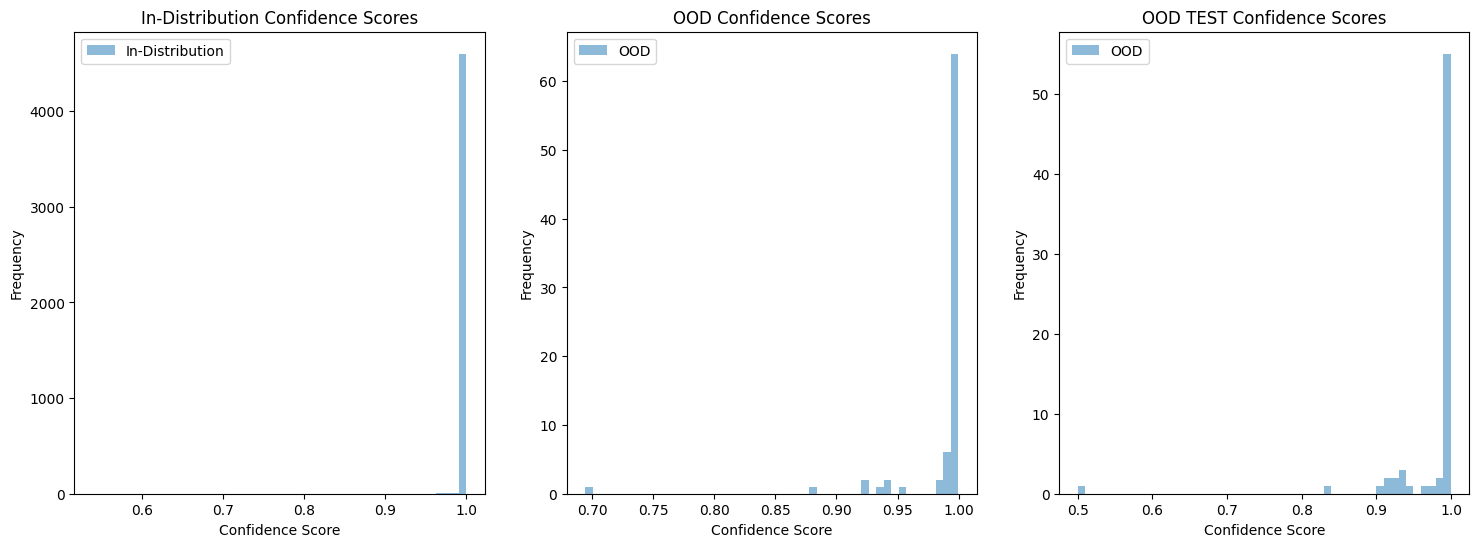

In [75]:
import torch
import numpy as np
import matplotlib.pyplot as plt

batch_size=5000
model_name = "best_ICELSTMAmodel"
model = torch.load(f"models/{model_name}_ood.pth").to(device)


def get_confidence_scores(model, data_loader):
    model.eval()
    confidence_scores = []
    with torch.no_grad():
        for inputs,_ in data_loader:
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            max_probs, _ = torch.max(probabilities, dim=1)
            confidence_scores.extend(max_probs.cpu().numpy())
    return confidence_scores

train_df = pd.read_csv('data/atis/train.tsv', sep='\t', header=None, names=["text", "label"])
train_data = tokenizer.process_data(train_df, device=device)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

ood_df=pd.read_csv('data/atis/ood.tsv', sep='\t', header=None, names=["text", "label"])
ood_data = tokenizer.process_data(ood_df, device=device)
ood_loader= DataLoader(ood_data, shuffle=True, batch_size=batch_size)
print("Number of ood samples:", ood_data.tensors[0].size())


ood_test_df=pd.read_csv('data/atis/ood_test.tsv', sep='\t', header=None, names=["text", "label"])
ood_test_data = tokenizer.process_data(ood_test_df, device=device)
ood_test_loader= DataLoader(ood_test_data, shuffle=True, batch_size=batch_size)
print("Number of ood samples:", ood_test_data.tensors[0].size())


# Assuming train_loader and ood_loader are DataLoader objects for your in-distribution and OOD data
train_confidence_scores = get_confidence_scores(model, train_loader)
ood_confidence_scores = get_confidence_scores(model, ood_loader)
ood_test_confidence_scores = get_confidence_scores(model, ood_test_loader)


# Creating subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plotting histograms on subplots
axs[0].hist(train_confidence_scores, bins=50, alpha=0.5, label='In-Distribution')
axs[0].set_title('In-Distribution Confidence Scores')
axs[0].set_xlabel('Confidence Score')
axs[0].set_ylabel('Frequency')
axs[0].legend()

axs[1].hist(ood_confidence_scores, bins=50, alpha=0.5, label='OOD')
axs[1].set_title('OOD Confidence Scores')
axs[1].set_xlabel('Confidence Score')
axs[1].set_ylabel('Frequency')
axs[1].legend()

axs[2].hist(ood_test_confidence_scores, bins=50, alpha=0.5, label='OOD')
axs[2].set_title('OOD TEST Confidence Scores')
axs[2].set_xlabel('Confidence Score')
axs[2].set_ylabel('Frequency')
axs[2].legend()
# Displaying the plots
plt.show()


In [76]:
print("How the model performs on OOD data")
y_pred=predict(model, ood_df, tokenizer, device)
print(y_pred)

print("How the model performs on OOD data Test")
y_pred=predict(model, ood_test_df, tokenizer, device)
print(y_pred)

How the model performs on OOD data
['<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>' '<unknown>'
 '<unknown>' '<u

### Check "I want to book a hotel room near Miami Beach" by both Models

In [77]:
model_name = "best_ICELSTMAmodel"

# Load the trained model and tokenizer from saved files
model_without_ood = torch.load(f"models/{model_name}.pth").to(device)
# Your query string
query_str = "I want to book a hotel room near miami beach"

# Creating a DataFrame with the query string
query = pd.DataFrame([query_str], columns=['text'])
print("Model trained without OOD, Response=" + predict(model_without_ood, query, tokenizer, device))
print("Model trained with OOD, Response=" + predict(model, query, tokenizer, device))


['Model trained without OOD, Response=flight']
['Model trained with OOD, Response=<unknown>']


## Check "what a bizzare situation, I had not expected it"

In [78]:
model_name = "best_ICELSTMAmodel"

# Load the trained model and tokenizer from saved files
model_without_ood = torch.load(f"models/{model_name}.pth").to(device)
# Your query string
query_str = "what a bizzare situation, I had not expected it"

# Creating a DataFrame with the query string
query = pd.DataFrame([query_str], columns=['text'])
print("Model trained without OOD, Response=" + predict(model_without_ood, query, tokenizer, device))
print("Model trained with OOD, Response=" + predict(model, query, tokenizer, device))

['Model trained without OOD, Response=abbreviation']
['Model trained with OOD, Response=<unknown>']
